In [ ]:
#####################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
#####################################################################################
# Analysis of frequency spectra of movements (extracted by LFTD). 
#####################################################################################

In [1]:
##############################################################################################################
# Residual analysis & frequency spectra (below)
# Described in:
# https://books.google.sk/books?id=_bFHL08IWfwC&pg=PA70&lpg=PA70&dq=choose+cutoff+frequency+residual+analysis&source=bl&ots=JmiubsdbS1&sig=mdtF6vFed-2ITMUlGRnsIwMf_vk&hl=en&sa=X&ved=0ahUKEwjpzZDbmq3aAhVNYVAKHQn4B44Q6AEIQDAE#v=onepage&q=choose%20cutoff%20frequency%20residual%20analysis&f=false
# Suggested by:
# http://alexalspach.com/cv/files/papers/2016-Agarwal_AlMoubayed_Alspach_Kim_Carter_Lehman_Yamane-Imitating_Human_Movement_with_Teleoperated_Robotic_Head.pdf
# DONE
##############################################################################################################

import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from postprocessingutils import smoother_LPBF
from evalutils import radToDeg

fc_range = np.linspace(0.5, 10., 20)
fc_range = np.linspace(0.5, 49.5, 99)

N_targets = 11
TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs'] # sorted VIDs
all_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_VIDs.npz')['VIDs']
PF_nonsmooth = np.load('./../Dataset/'+TE_folder+'/te_PF_nonsmooth.npz')['PF_nonsmooth']
PF_nonsmooth = PF_nonsmooth[:, :N_targets]

Res = np.zeros( len(fc_range) ) # store residuals (summed over all angles over all VIDs) for each cut-off frequency
Res_by_angle = np.zeros( (len(fc_range), N_targets) ) # residuals for each angle separately
st = time.time()
for i, fc in enumerate(fc_range):
    #R_VID = []
    sqr_VID_means = []
    for VID in unique_srt_VIDs:

        # Range of indices in all_srt_VIDs correspponding to this VID
        rangeI = np.argwhere(all_srt_VIDs == VID)[:,0]
        # Temporal nonsmooth data series for current VID
        PF_nonsmooth_VID = np.copy(PF_nonsmooth[rangeI])
        
        # Filter
        PF_smooth_VID = smoother_LPBF(PF_nonsmooth_VID, fc, constrain=False)
        # Calculate MSE
        sqr_VID_means.append( np.mean( np.square(PF_smooth_VID - PF_nonsmooth_VID), axis=0 ) ) # mean over the sequence 
                             
    # Calculate residual for this fc (over all VIDs)
    Res_by_angle[i] = np.sqrt( np.mean(sqr_VID_means, axis=0) )
    Res[i] = np.sqrt( np.mean(sqr_VID_means) ) # mean over all angles
Res = radToDeg(Res)
Res_by_angle = radToDeg(Res_by_angle)
print "Time taken: ", (time.time()-st), " s", "\t\t #fc = ", len(fc_range)

Time taken:  15.3021168709  s 		 #fc =  99


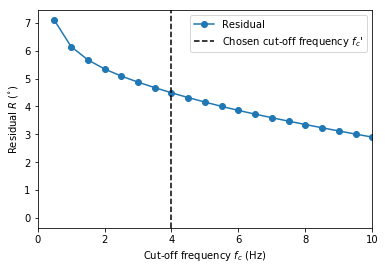

fc = 4 => where R drops below 3 degrees: fc=4 was chosen so that the residual drops below 3 degrees
Residual drops below 3 degrees for all 11 angles
Residual is: 4.48941577208  at freq  4.0
Residual is: 4.01978625035  at freq  4.0


In [46]:
plt.figure()
plt.plot(fc_range, Res, 'o-', label='Residual') # in degrees
stds = np.std(Res_by_angle, axis=1)
means = np.mean(Res_by_angle, axis=1)# radToDeg(Res)

fc_opt = 4.
plt.axvline(x=fc_opt, color='k', linestyle='--', label='Chosen cut-off frequency $f_c$\'')

plt.ylabel('Residual $R$ ($^{\circ}$)')
plt.xlabel('Cut-off frequency $f_c$ (Hz)')
plt.xlim(0, max(fc_range) + 0.5)
plt.xlim(0, 10)
plt.legend()
plt.show()
print "fc = 4 => where R drops below 3 degrees: fc=4 was chosen so that the residual drops below 3 degrees"
print "Residual drops below 3 degrees for all 11 angles"
print "Residual is:", Res[np.argwhere(fc_range == fc_opt)[0][0]], " at freq ", fc_opt
print "Residual is:", means[np.argwhere(fc_range == fc_opt)[0][0]], " at freq ", fc_opt

In [1]:
#######################################################################################################
# Frequency spectrum analysis of joints' movements (Y_true) (11 angles)
#######################################################################################################
# Based on: http://homes.ieu.edu.tr/skondakci/courses/CE476/frequency%20spectrum%20with%20scipy.pdf

import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from scipy import fft

TE_folder = 'TrainingExamples_16kHz'
unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs'] # sorted VIDs
all_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_VIDs.npz')['VIDs']

def getSpectrum(y):
    """
    Get a Single-Sided Amplitude Spectrum of y(t)
    """
    fs = 100.
    n = len(y) # length of the signal
    k = np.arange(n)
    frq = fs * k / n # two sides frequency range
    frq = frq[range(n/2)] # one side frequency range
    Y = fft(y, n)/n # fft computing and normalization
    Y = Y[range(n/2)]
    
    return (frq,abs(Y)) # (x,y) for plotting

RAW GROUND TRUTHS: Frequency spectra of movements of all 11 joint angles of all subjects


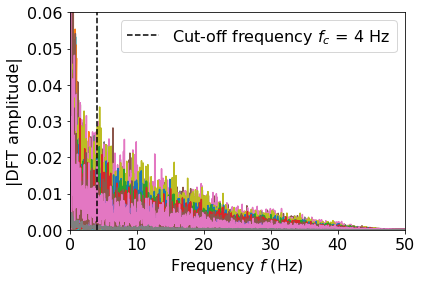

In [11]:
#####################################################################################
# Freq. spectra for non-smooth (raw) gorund truths

import matplotlib
matplotlib.rcParams.update({'font.size': 16})

print "RAW GROUND TRUTHS: Frequency spectra of movements of all 11 joint angles of all subjects"
PF = np.load('./../Dataset/'+TE_folder+'/te_PF_nonsmooth.npz')['PF_nonsmooth']
PF = PF[:, :11]
N_targets = PF.shape[1]
X = []
Y = []
for VID in unique_srt_VIDs:
    mask = np.argwhere(all_srt_VIDs == VID)[:,0]
    PF_VID = PF[mask]
    for i in range(N_targets):
        x_data, y_data = getSpectrum(PF_VID[:,i])
        X.append( x_data )
        Y.append( y_data )
fc = 4.
# plt.figure(figsize=(14,5))
plt.figure()
for x,y in zip(X, Y):
    plt.plot(x, y)
plt.xlim(0., 50)
plt.ylim(0, 0.06)
# plt.ylim(0, 0.09)
plt.ylabel('|DFT amplitude|')
plt.xlabel('Frequency $f$ (Hz)')
plt.axvline(x=fc, color='k', linestyle='--', label='Cut-off frequency $f_c$ = {:.0f} Hz'.format(fc))
plt.legend()
plt.show()

low-pass filtered GROUND TRUTHS: Frequency spectra of movements of all 11 joint angles of all subjects


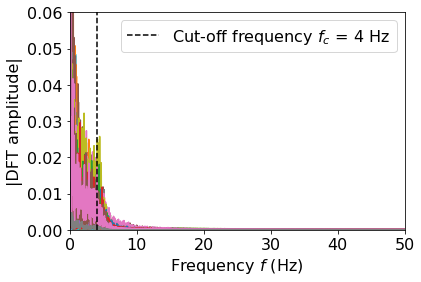

In [12]:
#####################################################################################
# Freq. spectra for low-pass filtered gorund truths

print "low-pass filtered GROUND TRUTHS: Frequency spectra of movements of all 11 joint angles of all subjects"
PF = np.load('./../Dataset/'+TE_folder+'/te_PF_smooth_LPBF_5.npz')['PF_smooth_LPBF']
PF = PF[:, :11]
N_targets = PF.shape[1]
X = []
Y = []
for VID in unique_srt_VIDs:
    mask = np.argwhere(all_srt_VIDs == VID)[:,0]
    PF_VID = PF[mask]
    for i in range(N_targets):
        x_data, y_data = getSpectrum(PF_VID[:,i])
        X.append( x_data )
        Y.append( y_data )
fc = 4.
# plt.figure(figsize=(14,5))
plt.figure()
for x,y in zip(X, Y):
    plt.plot(x, y)
plt.xlim(0., 50)
plt.ylim(0, 0.06)
plt.ylabel('|DFT amplitude|')
plt.xlabel('Frequency $f$ (Hz)')
plt.axvline(x=fc, color='k', linestyle='--', label='Cut-off frequency $f_c$ = {:.0f} Hz'.format(fc))
plt.legend()
plt.show()